# Normalized Difference Vegtation Index (Vegetation monitoring)

In [2]:
# Define the global variables

# Define analysis period
# NDVI calculations for the entire year
start_date = '2023-01-01'
end_date = '2023-12-31'

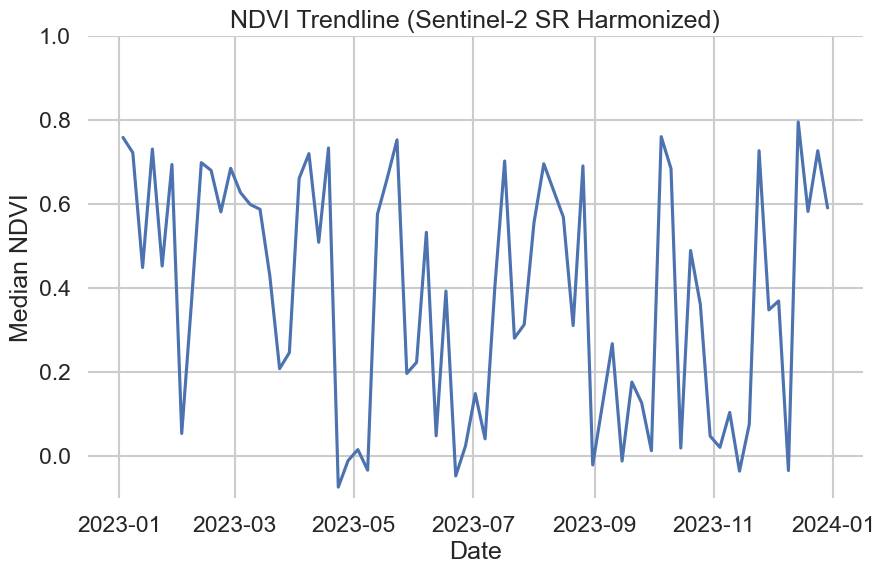

In [ ]:
# ============================================
# NDVI (Vegetation Monitoring with GEE + Python)
# ============================================

# ---- 1. Imports & Global Settings ----

import ee
import geemap
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# Comment this line if not using Colab and running locally
from google.colab import userdata

sns.set_theme(context='talk', style='whitegrid', palette='deep')

# ---- 2. Authenticate and Initialize GEE ----
# Get the GEE project name from Colab userdata
# Use the following for Colab from Secrets 
EE_PROJECT_NAME = userdata.get('EE_PROJECT_NAME')
# or hardcode the project name here for local runs
#EE_PROJECT_NAME = 'ee-projectname'  # Replace with your GEE project name

# Trigger authentication flow.
ee.Authenticate()

# Initialize the Earth Engine library.
ee.Initialize(project=EE_PROJECT_NAME)

# ---- 3. Define Region of Interest (ROI) ----
# roi = ee.Geometry.Point([76.9627, 11.0168]).buffer(10000)  # 10 km buffer around point
roi = ee.Geometry.Polygon([[76.65842961378894,9.122675187222],
 [76.6607470423778,9.123617974411596],
 [76.66059683867297,9.124099960158484],
 [76.65852080889545,9.12343789165775],
 [76.65842961378894,9.122675187222]])


# ---- 4. Load Sentinel-2 Data ----
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate(start_date, end_date)
)

# ---- 5. Cloud Masking Function ----
# Cloud masking function using QA60 (bitwise mask for cloud bits)
def mask_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10  # Bit 10: clouds
    cirrusBitMask = 1 << 11 # Bit 11: cirrus
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0)
    )
    return image.updateMask(mask)
# Apply cloud mask
collection_masked = collection.map(mask_clouds)

# ---- 6. Compute NDVI and Keep Timestamp ----
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi).set('system:time_start', image.get('system:time_start'))

# Add NDVI band
collection_ndvi = collection_masked.map(add_ndvi)

# ---- 7. Calculate Median of all pixels for each image ----
def reduce_image(image):
    stats = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    ndvi = stats.get('NDVI')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'ndvi': ndvi})

# Apply reduction → FeatureCollection with NDVI time series
ndvi_features = collection_ndvi.map(reduce_image).filter(
    ee.Filter.notNull(['ndvi'])
)

# ---- 8. Convert GEE Output to Data ----
data = ndvi_features.getInfo()['features']

# ---- 9. Plot Daily NDVI Trend ----
dates = []
ndvi_values = []
for f in data:
    prop = f['properties']
    dates.append(datetime.strptime(prop['date'], '%Y-%m-%d'))
    ndvi_values.append(prop['ndvi'])

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=dates, y=ndvi_values, markers='o')
plt.ylim(-0.1, 1)
plt.xlabel('Date')
plt.ylabel('Median NDVI')
plt.title('NDVI Trendline (Sentinel-2 SR Harmonized)')
plt.box(False)
plt.grid(True)
plt.show()


In [8]:
# ---- 10. Visualize Median NDVI Map ----
Map = geemap.Map(center=[9.122675187222, 76.65842961378894], zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayer(roi, {}, 'ROI')
ndvi_vis = {
  'min': 0.0,
  'max': 1.0,'palette': [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']}
ndvi_image = collection_ndvi.median().select('NDVI')
Map.addLayer(ndvi_image, ndvi_vis, 'Median NDVI')
# Add legend
Map.add_colorbar(
    vis_params=ndvi_vis,
    label="NDVI",
    layer_name="NDVI"
)
Map

Map(center=[9.122675187222, 76.65842961378894], controls=(WidgetControl(options=['position', 'transparent_bg']…

# Time-Series Windowing Approach to Remove Anomalies

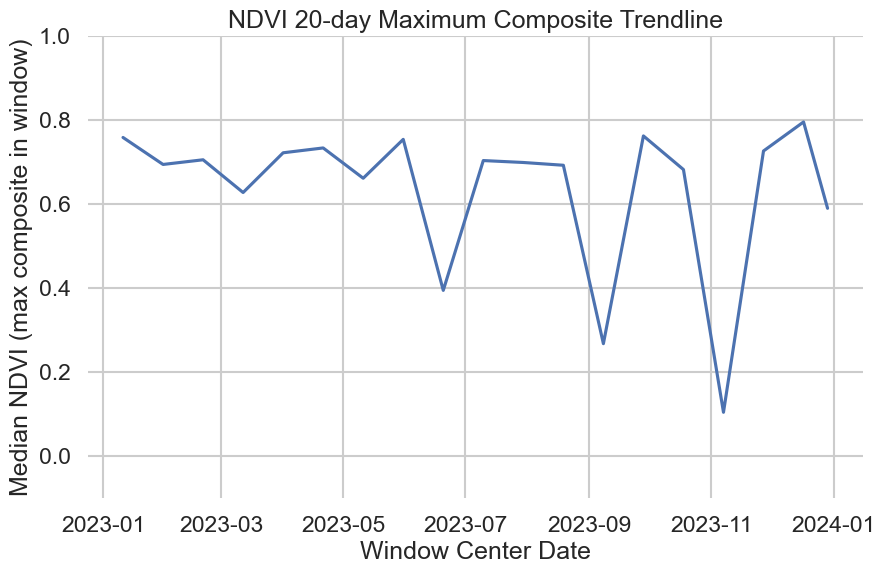

In [9]:
# Define 20-day window size for the composite
window_size = 20  # days

# Function to create rolling window composites
def make_window_composites(start_str, end_str, window_days):
    # Generate window start/end dates
    start = datetime.strptime(start_str, '%Y-%m-%d')
    end = datetime.strptime(end_str, '%Y-%m-%d')
    # Generate time windows
    windows, composites = [], []
    while start < end:
        w_end = start + timedelta(days=window_days)
        if w_end > end:
            w_end = end
        windows.append((start, w_end))
        start = w_end

     # Build composites
    for w_start, w_end in windows:
        s = w_start.strftime('%Y-%m-%d')
        e = w_end.strftime('%Y-%m-%d')
        col = collection_ndvi.filterDate(s, e)
        # Compute NDVI max composite for window
        ndvi_max = col.select('NDVI').max()
        # Store composite and window mid-date
        mid_date = w_start + (w_end - w_start) / 2
        composites.append({'image': ndvi_max, 'date': mid_date})
    return composites

# Create composites for 20-day windows
composites = make_window_composites(start_date, end_date, window_size)

# Compute ROI median NDVI for each composite
dates, ndvi_values = [], []
for comp in composites:
    stats = comp['image'].reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    # Request NDVI value
    ndvi = stats.getInfo().get('NDVI')
    if ndvi is not None:
        dates.append(comp['date'])
        ndvi_values.append(ndvi)

# Plot windowed NDVI
plt.figure(figsize=(10, 6))
sns.lineplot(x=dates, y=ndvi_values, markers=True)
plt.ylim(-0.1, 1)
plt.xlabel('Window Center Date')
plt.ylabel('Median NDVI (max composite in window)')
plt.title('NDVI 20-day Maximum Composite Trendline')
plt.grid(True)
plt.box(False)
plt.show()


# Phenology Detection

In [ ]:
!pip install earthengine-api geopandas scipy matplotlib

In [ ]:
import ee
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from datetime import timedelta

In [ ]:
ee.Authenticate()
ee.Initialize(project='cropy5')

In [ ]:
# --- PARAMETERS ---
roi = ee.Geometry.Polygon(
    [[
        [75.0, 31.0],
        [75.2, 31.0],
        [75.2, 30.8],
        [75.0, 30.8],
        [75.0, 31.0]
    ]],
    None, False
)

start_date = '2023-06-01'
end_date   = '2023-11-30'
window_days = 15

In [ ]:
# --- LOAD S2 AND COMPUTE NDVI ---
def addNDVI(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return img.addBands(ndvi)

s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        .map(addNDVI)
        .select('NDVI'))

In [ ]:
# --- CREATE 15-DAY MAX NDVI COMPOSITES ---
def make_window_composites(coll, start_str, end_str, window_days):
    # Generate window start/end dates
    start = datetime.datetime.fromisoformat(start_str)
    end = datetime.datetime.fromisoformat(end_str)
    windows = []
    while start < end:
        w_end = start + timedelta(days=window_days)
        if w_end > end:
            w_end = end
        windows.append((start, w_end))
        start = w_end

    composites = []
    for w_start, w_end in windows:
        s = w_start.strftime('%Y-%m-%d')
        e = w_end.strftime('%Y-%m-%d')
        col = coll.filterDate(s, e)
        # Compute NDVI max composite for window
        ndvi_max = col.select('NDVI').max()
        # Store composite and window mid-date
        mid_date = w_start + (w_end - w_start) / 2
        composites.append({'image': ndvi_max, 'date': mid_date})
    return composites

In [ ]:
composites = make_window_composites(s2, start_date, end_date, window_days)

# Compute ROI median NDVI for each composite
ndvi_dict = {}
for comp in composites:
    stats = comp['image'].reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=roi,
        scale=10,
        bestEffort=True
    )
    # Request NDVI value
    ndvi = stats.getInfo().get('NDVI')
    if ndvi is not None:
        ndvi_dict[comp['date'].date()] = float(ndvi)

print("Raw NDVI dict:", ndvi_dict)

In [ ]:
# --- SMOOTH NDVI WITH SAVITZKY-GOLAY ---
dates_sorted = sorted(ndvi_dict.keys())
ndvi_vals = [ndvi_dict[d] for d in dates_sorted]

y = np.array(ndvi_vals)
x = np.arange(len(y))  # just index for smoothing

ndvi_smooth = savgol_filter(y, window_length=5, polyorder=2)

In [ ]:
# --- DETECT SOS, POS, EOS ---
# POS = peak
peaks, _ = find_peaks(ndvi_smooth)
if len(peaks) > 0:
    pos_idx = peaks[np.argmax(ndvi_smooth[peaks])]
else:
    pos_idx = np.argmax(ndvi_smooth)

# SOS = first slope rise before POS
rate_of_change = np.diff(ndvi_smooth)
sos_candidates = np.where(rate_of_change[:pos_idx] > 0.2)[0]
sos_idx = sos_candidates[0] if len(sos_candidates) else 0

# EOS = first slope decline after POS
eos_candidates = np.where(rate_of_change[pos_idx:] < 0.2)[0]
eos_idx = pos_idx + eos_candidates[-1] if len(eos_candidates) else len(ndvi_smooth)-1

In [ ]:
import plotly.graph_objects as go

# --- Plotly Interactive Plot ---
fig = go.Figure()

# Raw NDVI
fig.add_trace(go.Scatter(
    x=dates_sorted,
    y=y,
    mode='lines+markers',
    name="Raw NDVI",
    line=dict(dash='dash', color='gray'),
    marker=dict(symbol='circle-open', size=8)
))

# Smoothed NDVI
fig.add_trace(go.Scatter(
    x=dates_sorted,
    y=ndvi_smooth,
    mode='lines+markers',
    name="Smoothed NDVI",
    line=dict(color='red', width=2),
    marker=dict(symbol='circle', size=6)
))

# SOS marker
fig.add_trace(go.Scatter(
    x=[dates_sorted[sos_idx]],
    y=[ndvi_smooth[sos_idx]],
    mode='markers+text',
    name="SOS",
    marker=dict(color='green', size=12, symbol='diamond'),
    text=["SOS"],
    textposition="top center"
))

# POS marker
fig.add_trace(go.Scatter(
    x=[dates_sorted[pos_idx]],
    y=[ndvi_smooth[pos_idx]],
    mode='markers+text',
    name="POS",
    marker=dict(color='blue', size=12, symbol='star'),
    text=["POS"],
    textposition="top center"
))

# EOS marker
fig.add_trace(go.Scatter(
    x=[dates_sorted[eos_idx]],
    y=[ndvi_smooth[eos_idx]],
    mode='markers+text',
    name="EOS",
    marker=dict(color='magenta', size=12, symbol='x'),
    text=["EOS"],
    textposition="top center"
))

# Layout settings
fig.update_layout(
    title="NDVI Time Series (15-day Max Composites)",
    xaxis_title="Date",
    yaxis_title="NDVI",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

# Comparing Sentinel2, Landsat and Modis

In [ ]:
import ee
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

# ---- Authenticate and initialize EE ----
try:
    ee.Initialize(project='cropy5')
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='cropy5')

# ==== USER INPUTS ====
roi = ee.Geometry.Polygon(
    [[
        [75.0, 31.0],
        [75.2, 31.0],
        [75.2, 30.8],
        [75.0, 30.8],
        [75.0, 31.0]
    ]],
    None, False
)
start_date = '2023-01-01'
end_date   = '2023-12-31'

# ===================== Sentinel-2 (SR Harmonized) =====================
def mask_s2_sr(image):
    qa = image.select('QA60')
    cloud_bit_mask  = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    scaled = image.updateMask(mask) \
                  .multiply(0.0001) \
                  .select(['B4', 'B8'], ['red', 'nir'])
    return scaled.copyProperties(image, image.propertyNames())

s2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 50))
    .map(mask_s2_sr)
    .map(lambda img: img.addBands(
        img.normalizedDifference(['nir','red']).rename('NDVI')))
)

# ===================== Landsat 8/9 Collection 2, Level 2 SR =====================
OPTICAL_BANDS = ['SR_B2','SR_B3','SR_B4','SR_B5']
SCALE = 0.0000275
OFFSET = -0.2

def mask_ls_l2(image):
    qa = image.select('QA_PIXEL')
    mask = (qa.bitwiseAnd(1 << 1).eq(0)
            .And(qa.bitwiseAnd(1 << 3).eq(0))
            .And(qa.bitwiseAnd(1 << 5).eq(0))
            .And(qa.bitwiseAnd(1 << 7).eq(0)))
    scaled = image.select(OPTICAL_BANDS).multiply(SCALE).add(OFFSET)
    scaled = scaled.updateMask(mask)
    scaled = scaled.select(['SR_B4','SR_B5'], ['red','nir'])
    return scaled.copyProperties(image, image.propertyNames())

ls8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
       .filterBounds(roi).filterDate(start_date, end_date).map(mask_ls_l2))
ls9 = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
       .filterBounds(roi).filterDate(start_date, end_date).map(mask_ls_l2))

landsat = ls8.merge(ls9).map(lambda img: img.addBands(
    img.normalizedDifference(['nir','red']).rename('NDVI'))
)

# ===================== 20-day composites =====================
def composite_20day(ic, source_name, scale):
    start = datetime.fromisoformat(start_date)
    end   = datetime.fromisoformat(end_date)
    step = timedelta(days=20)
    feats = []

    while start < end:
        period_end = min(start + step, end)
        ic_period = ic.filterDate(start.isoformat(), period_end.isoformat())
        if ic_period.size().getInfo() > 0:
            ndvi_max = ic_period.select('NDVI').max()
            mean_val = ndvi_max.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=scale,
                maxPixels=1e13
            ).get('NDVI')
            val = ee.Number(mean_val).getInfo()
            if val is not None:
                feats.append({
                    'date': start + step/2,
                    'ndvi': val,
                    'source': source_name
                })
        start += step
    return feats

s2_feats = composite_20day(s2, 'Sentinel-2', 10)
ls_feats = composite_20day(landsat, 'Landsat 8/9', 30)

df = pd.DataFrame(s2_feats + ls_feats).sort_values('date')

# ===================== Apply Savitzky–Golay smoothing =====================
smoothed = []
for src, sub in df.groupby('source'):
    if len(sub) >= 3:
        ndvi_smooth = savgol_filter(sub['ndvi'].values, window_length=3, polyorder=1)
    else:
        ndvi_smooth = sub['ndvi'].values
    tmp = sub.copy()
    tmp['ndvi_smooth'] = ndvi_smooth
    smoothed.append(tmp)

df_smooth = pd.concat(smoothed)

# ===================== Interactive Plotly plot =====================
fig = go.Figure()

for src, sub in df_smooth.groupby('source'):
    # Raw trace
    fig.add_trace(go.Scatter(
        x=sub['date'], y=sub['ndvi'],
        mode='lines+markers',
        name=f"{src} raw",
        line=dict(dash='dot'),
        opacity=0.5
    ))
    # Smoothed trace
    fig.add_trace(go.Scatter(
        x=sub['date'], y=sub['ndvi_smooth'],
        mode='lines+markers',
        name=f"{src} smoothed",
    ))

fig.update_layout(
    title="20-day Max NDVI (Mean over ROI)<br>Sentinel-2 vs Landsat 8/9",
    xaxis_title="Date",
    yaxis_title="NDVI (unitless)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()
